In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Ellipse
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

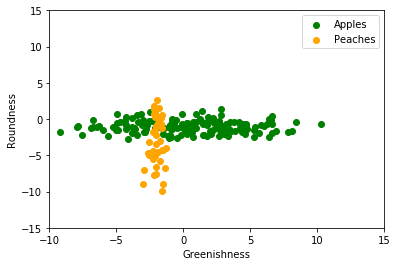

In [3]:
n_data = 200
n_data_class_0 = int(0.8 * n_data)
n_data_class_1 = n_data - n_data_class_0

C0 = np.array([[4, 0], [0, 1]])
C0 = C0 @ C0.T
m0 = np.array([1, -1])
x0 = np.random.multivariate_normal(m0, C0, size=n_data_class_0)

C1 = np.array([[0.3, 0], [0, 3]])
C1 = C1 @ C1.T
m1 = np.array([-2, -3])
x1 = np.random.multivariate_normal(m1, C1, size=n_data_class_1)

plt.scatter(x0[:, 0], x0[:, 1], color='green')
plt.scatter(x1[:, 0], x1[:, 1], color='orange') 
plt.xlim([-10, 15])
plt.ylim([-15, 15])
plt.xlabel("Greenishness")
plt.ylabel("Roundness")
plt.legend(["Apples", "Peaches"])
#plt.savefig('data.pdf')

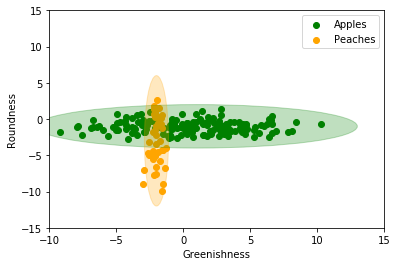

In [4]:
plot_cov_ellipse(C0, m0, nstd=3, alpha=0.25, color='green') 
plot_cov_ellipse(C1, m1, nstd=3, alpha=0.25, color='orange')
plt.scatter(x0[:, 0], x0[:, 1], color='green') 
plt.scatter(x1[:, 0], x1[:, 1], color='orange') 
plt.xlim([-10, 15])
plt.ylim([-15, 15])
plt.xlabel("Greenishness")
plt.ylabel("Roundness")
plt.legend(["Apples", "Peaches"])
#plt.savefig('model.pdf')

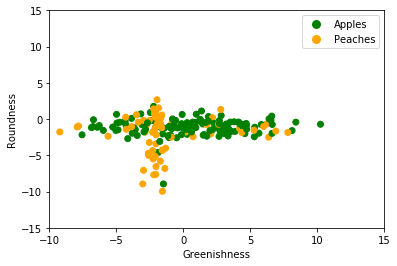

In [5]:
flip_prob = 0.2
labels = np.ones(n_data).astype('int')
labels[:n_data_class_0] = 0
color_labels = [''] * n_data
data = np.concatenate([x0, x1])

# flip labels
for i in range(n_data):
    if np.random.rand() < flip_prob:
        labels[i] = 1 - labels[i]
    color_labels[i] = 'green' if labels[i] == 0 else 'orange'
    
means = np.stack((np.mean(data[labels == 0], axis=0), np.mean(data[labels == 1], axis=0)))
sigma = np.stack((np.cov(data[labels == 0], rowvar=0), np.cov(data[labels == 1], rowvar=0)))
       
plt.scatter(data[:, 0], data[:, 1], color=color_labels)
plt.xlim([-10, 15])
plt.ylim([-15, 15])
plt.xlabel("Greenishness")
plt.ylabel("Roundness")
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Apples',
                          markerfacecolor='g', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Peaches',
                          markerfacecolor='orange', markersize=10)]
plt.legend(handles=legend_elements)
#plt.savefig('noisy.pdf')

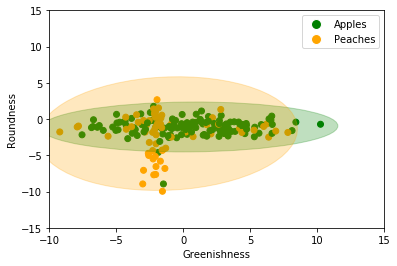

In [6]:
plot_cov_ellipse(sigma[0,:,:], means[0,:], nstd=3, alpha=0.25, color='green')
plot_cov_ellipse(sigma[1,:,:], means[1,:], nstd=3, alpha=0.25, color='orange')
        
plt.scatter(data[:, 0], data[:, 1], color=color_labels)
plt.xlim([-10, 15])
plt.ylim([-15, 15])
plt.xlabel("Greenishness")
plt.ylabel("Roundness")
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Apples',
                          markerfacecolor='g', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Peaches',
                          markerfacecolor='orange', markersize=10)]
plt.legend(handles=legend_elements)
#plt.savefig('model_noisy.pdf')

In [7]:
def expectation(means, sigma, gamma, x, yhat):
    prior = np.zeros((yhat.shape[0], 2))
    likelihood = np.zeros((yhat.shape[0], 2))
    for i in range(yhat.shape[0]):
        if yhat[i] == 0:
            prior[i] = np.array([1 - gamma[0], gamma[0]]) 
        else:
            prior[i] = np.array([gamma[1], 1 - gamma[1]]) 
        # likelihood
        for j in range(2):
            likelihood[i][j] = multivariate_normal.pdf(x[i], mean=means[j], cov=sigma[j])
       
    likelihood = likelihood * prior
    return likelihood / np.sum(likelihood, 1, keepdims=True)

In [8]:
def maximization(posterior, means, sigma, data, labels):
    new_means = np.zeros_like(means)
    new_sigma = np.zeros_like(sigma)
    new_gamma = np.zeros_like(gamma)
    for i in range(2):
        new_means[i,:] = np.average(data, axis=0, weights=posterior[:,i])
    for i in range(2):
        new_sigma[i,:,:] = np.cov(data - new_means[i,:], rowvar=False, aweights=posterior[:,i], ddof=0)
    
    new_gamma[0] = 1 - np.mean(posterior[(1-labels).astype('bool'), 0])
    new_gamma[1] = 1 - np.mean(posterior[(labels).astype('bool'), 1])
   
    return new_means, new_sigma, new_gamma

In [9]:
# initialize parameters
gamma = np.array([0.3, 0.3])
em_iter = 50

for k in range(em_iter):
    # E-step
    posterior = expectation(means, sigma, gamma, data, labels)
    # M-step
    means, sigma, gamma = maximization(posterior, means, sigma, data, labels)

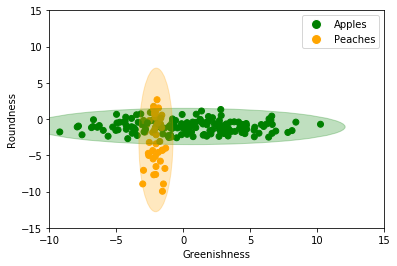

In [10]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange","green"])
plot_cov_ellipse(sigma[0,:,:], means[0,:], nstd=3, alpha=0.25, color='green')
plot_cov_ellipse(sigma[1,:,:], means[1,:], nstd=3, alpha=0.25, color='orange')
plt.scatter(data[:, 0], data[:, 1], c=posterior[:,0], cmap=cmap)
plt.xlim([-10, 15])
plt.ylim([-15, 15])
plt.xlabel("Greenishness")
plt.ylabel("Roundness")
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Apples',
                          markerfacecolor='g', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Peaches',
                          markerfacecolor='orange', markersize=10)]
plt.legend(handles=legend_elements)
#plt.savefig('model_immu.pdf')